In [1]:
import os
import numpy as np
import pandas as pd
import pulse2percept as p2p
import p2pspatial

import skimage
import skimage.io as skio
import skimage.transform as skit

%matplotlib inline
import matplotlib.pyplot as plt

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-01-23 17:06:37,663 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
subject = '12-005'

In [3]:
X, y = p2pspatial.load_data(os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape'),
                            subject=subject, amplitude=2.0)
electrodes = X.electrode.unique()
electrodes

array(['A01', 'A04', 'A08', 'B01', 'B03', 'B09', 'C07', 'C10', 'D01',
       'D08', 'D10', 'E01', 'A06', 'D04', 'D07', 'E03', 'E07', 'E10',
       'F02', 'F04', 'F06', 'F09'], dtype=object)

In [4]:
Xtrafo, ytrafo = p2pspatial.transform_mean_images(X, y)

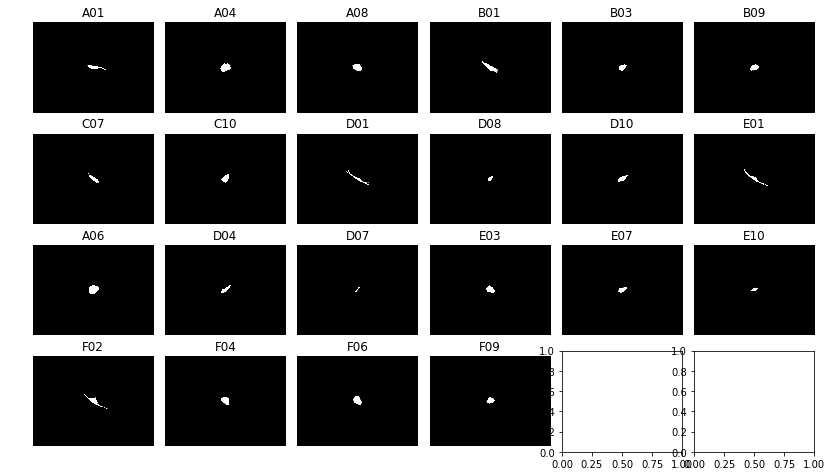

In [5]:
nrows = 4
ncols = int(np.ceil(len(Xtrafo) / nrows))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 2 * nrows))
for Xrow, yrow, ax in zip(Xtrafo.iterrows(), ytrafo.iterrows(), axes.ravel()):
    ax.imshow(yrow[1]['image'], cmap='gray')
    ax.set_title(Xrow[1]['electrode'])
    ax.axis('off')
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# An Example

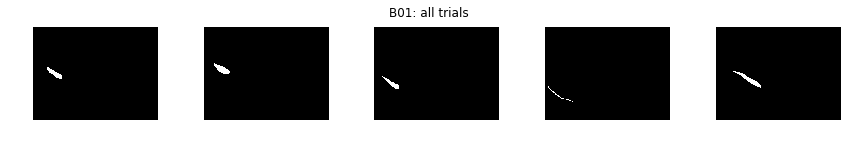

In [6]:
electrode = electrodes[3]
ncols = 5
nrows = int(np.ceil(len(X[X.electrode == electrodes[0]]) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 2 * nrows))

imgs = []
areas = []
orientations = []
for Xrow, ax in zip(X[X.electrode == electrode].iterrows(), axes.ravel()):
    _, row = Xrow
    img = skio.imread(os.path.join(row['folder'], row['filename']), as_grey=True)
    img = skimage.img_as_float(img)
    props = p2pspatial.imgproc.get_region_props(img, thresh=0)
    assert not np.isnan(props.area)
    assert not np.isnan(props.orientation)
    areas.append(props.area)
    orientations.append(props.orientation)
    imgs.append(img)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
fig.suptitle('%s: all trials' % electrode)
fig.tight_layout()

In [7]:
print('mean area:', np.mean(areas))
print('mean orientation:', np.mean(orientations))

mean area: 4531.2
mean orientation: -0.561622416735


In [8]:
img_diced = []
seed = None
for i, img in enumerate(imgs):
    img = p2pspatial.imgproc.center_phosphene(img)
    if i == 0:
        # Save first image as seed image
        seed = img
    else:
        # Compare image to seed image
        assert seed is not None
        _, _, params = p2pspatial.imgproc.srd_loss((seed, img), return_raw=True)
        img = p2pspatial.imgproc.scale_phosphene(img, params['scale'])
        img = skit.rotate(img, params['angle'], order=3)
    img_diced.append(img)

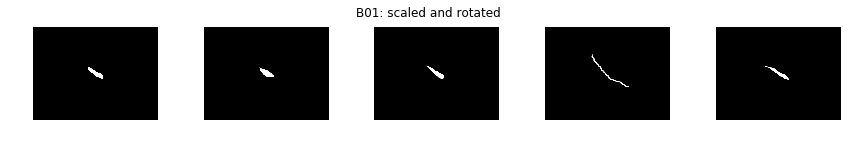

In [9]:
ncols = 5
nrows = int(np.ceil(len(img_diced) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 2 * nrows))

imgs = []
for img, ax in zip(img_diced, axes.ravel()):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
fig.suptitle('%s: scaled and rotated' % electrode)
fig.tight_layout()

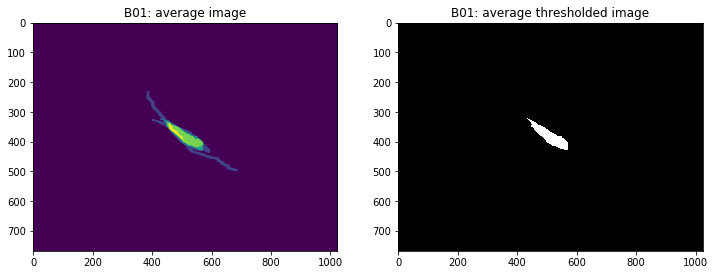

In [10]:
import functools
img_avg = functools.reduce(lambda x, y: x + y, img_diced)
img_avg_th = p2pspatial.imgproc.get_thresholded_image(img_avg, thresh='otsu')

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(img_avg)
plt.title('%s: average image' % electrode)

plt.subplot(122)
plt.imshow(img_avg_th, cmap='gray')
plt.title('%s: average thresholded image' % electrode)

In [11]:
props = p2pspatial.imgproc.get_region_props(img_avg_th, thresh=0)
img_angle = np.mean(orientations) - props.orientation
print(props.orientation, '=?', np.mean(orientations), 'diff:', img_angle)

-0.5956133412401428 =? -0.561622416735 diff: 0.0339909245052


In [12]:
img_final = skit.rotate(img_avg_th, np.rad2deg(img_angle), order=3)
props = p2pspatial.imgproc.get_region_props(img_final, thresh=0)
print(props.orientation, '==', np.mean(orientations))

-0.5636630535773638 == -0.561622416735


In [13]:
img_scale = np.sqrt(np.mean(areas) / props.area)
img_final = p2pspatial.imgproc.scale_phosphene(img_final, img_scale)
props = p2pspatial.imgproc.get_region_props(img_final, thresh=0)
print(props.area, '==', np.mean(areas))

4975 == 4531.2


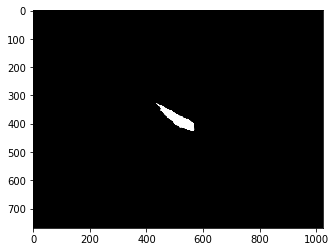

In [14]:
plt.imshow(img_final, cmap='gray')